# Gesture Recognition


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy
import os
import cv2
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras import Input
from tensorflow.keras.applications import MobileNetV2
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, GRU, Flatten, Reshape, GlobalAveragePooling3D, TimeDistributed, LSTM, BatchNormalization, Dropout, SimpleRNN, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

We set the random seed so that the results don't vary drastically.

Shuffled the rows of csv because if the images of same actions are consecutively, model can learn the pattern and will perform badly on new data.

In [2]:
train_doc = np.random.permutation(open('../input/gesture-data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../input/gesture-data/Project_data/val.csv').readlines())

batch_size = 16
img_height = 120
img_width = 120
third_dim = 14
num_epochs = 50

#### Function to plot the train loss, val loss, train accuracy and val accuracy.

In [3]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. We have to define a custom data generator.

In [4]:
def generator(source_path, folder_list, batch_size):
    img_idx = np.arange(9,23)             # Select only images with theses indexes from a video
    while True:                           # since not all the images are necessary.
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches):
            batch_data, batch_labels = batched_data(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels
        
        remain = len(t)%batch_size
        if  remain != 0:                  # if len of input data is not completely divisble by 
            batch_size = remain           # batch_size then we pass the rest of inputs in a last batch
            batch += 1
            batch_data, batch_labels = batched_data(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels

#### Shape of batch: (batch_size, frames per video, img_height, img_width, n_channels)

In [5]:
def batched_data(source_path,t,batch,batch_size,img_idx):
    batch_data = np.zeros((batch_size,third_dim,img_height,img_width,3))
    batch_labels = np.zeros((batch_size,5))
    for folder in range(batch_size):
        imgs = os.listdir(source_path+'/'+ t[folder + batch*batch_size].split(';')[0])
        for idx,item in enumerate(img_idx):
            image = cv2.imread(source_path+'/'+ t[folder + batch*batch_size].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            dim = (120,120)                 # Reshape images to 120 x 120
            if image.shape[0]==360:
                image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
            else:
                image = image[:,21:141]
                                            # normalize each image channels
            batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0]) - np.min(image[:,:,0])) #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1]) - np.min(image[:,:,1])) #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2]) - np.min(image[:,:,2])) #normalise and feed in the image


        batch_labels[folder, int(t[folder + batch*batch_size].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [6]:
# Calculate total number of train and val inputs

curr_dt_time = datetime.datetime.now()
train_path = '../input/gesture-data/Project_data/train'
val_path = '../input/gesture-data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


#### Model training function

In [7]:
def train_model(model, lr, train_path, val_path, train_doc, batch_size):
    
    # Create train and val generator.
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    # Save chackpoints for model. 
    # Model name consists of epoch number, train loss, val loss, train acc and val acc.
    
    model_name = './model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, patience = 3, min_lr = 1e-5)
    
    callbacks_list = [checkpoint, LR]
    
    # calculate the train and val steps
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    optimiser = Adam(learning_rate=lr)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                  verbose=1, callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

### Conv 3D model

In [8]:
batch_size = 32
img_height = 120
img_width = 120
third_dim = 14
num_epochs = 50

model = Sequential()
model.add(Conv3D(32, 3, activation='relu', input_shape=(third_dim,img_height,img_width,3)))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(Conv3D(32, 3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2)))
model.add(Conv3D(64, 3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(Conv3D(64, 3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2)))
model.add(Conv3D(128, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
                
lr = 0.0005
history = train_model(model, lr, train_path, val_path, train_doc, batch_size)

2022-01-29 07:01:26.790028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 07:01:26.924002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 07:01:26.924698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 07:01:26.926318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/50


2022-01-29 07:01:34.636102: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


21/21 [==============================] - 89s 4s/step - loss: 18.2011 - categorical_accuracy: 0.1991 - val_loss: 10.8833 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to ./model_init_2022-01-2907_01_26.578659/model-00001-18.20114-0.19910-10.88329-0.22000.h5
Epoch 2/50
21/21 [==============================] - 24s 1s/step - loss: 7.2210 - categorical_accuracy: 0.2340 - val_loss: 4.3688 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to ./model_init_2022-01-2907_01_26.578659/model-00002-7.22100-0.23395-4.36881-0.25000.h5
Epoch 3/50
21/21 [==============================] - 20s 982ms/step - loss: 3.2079 - categorical_accuracy: 0.1874 - val_loss: 2.2840 - val_categorical_accuracy: 0.1250

Epoch 00003: saving model to ./model_init_2022-01-2907_01_26.578659/model-00003-3.20789-0.18735-2.28399-0.12500.h5
Epoch 4/50
21/21 [==============================] - 19s 926ms/step - loss: 1.9603 - categorical_accuracy: 0.2180 - val_loss: 1.7404 - val_categorical_accuracy: 0.18

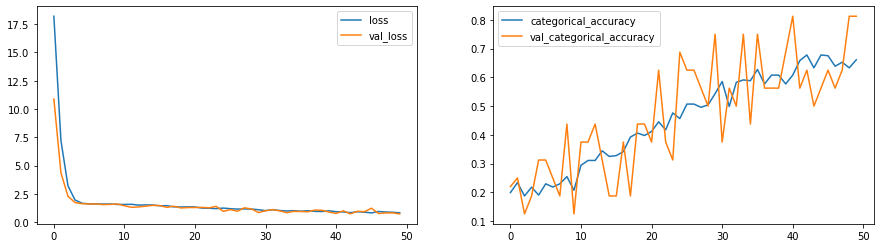

In [9]:
plot(history)

### CNN-LSTM model

In [10]:
batch_size = 32
img_height = 120
img_width = 120
third_dim = 14
num_epochs = 50
cnn = Sequential()
cnn.add(Conv2D(32, 3, activation='relu', input_shape=(img_height,img_width,3)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Conv2D(32, 3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Conv2D(64, 3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.5))
cnn.add(Conv2D(64, 3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.5))
cnn.add(Flatten())
print(cnn.summary())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(third_dim,img_height,img_width,3)))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax', kernel_regularizer=l2(0.1)))
print(model.summary())
lr = 0.0001

history = train_model(model, lr, train_path, val_path, train_doc, batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)       

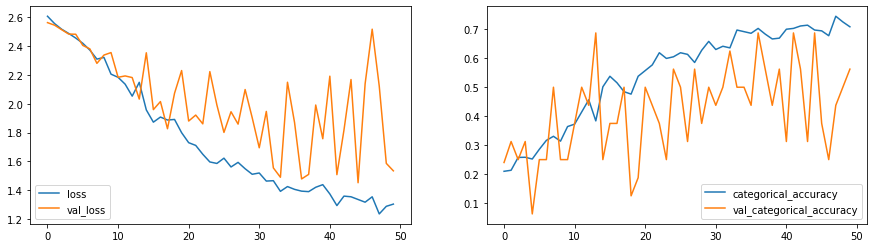

In [11]:
plot(history)

### MobileNet + LSTM

In [12]:
batch_size = 32
img_height = 120
img_width = 120
third_dim = 14
num_epochs = 50

base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
import keras
base_model = tf.keras.Sequential([
                          base_model, keras.layers.Dropout(0.3),
                          keras.layers.GlobalAveragePooling2D(),
])
model = Sequential()
model.add(TimeDistributed(base_model, input_shape=(third_dim,img_height,img_width,3)))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax', kernel_regularizer=l2(0.1)))
print(model.summary())
lr = 0.0001

history = train_model(model, lr, train_path, val_path, train_doc, batch_size)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 14, 1280)          2257984   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               721408    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 2,980,037
Trainable params: 722,053
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/50
21/21 [==============================] - 40s 2s/step - loss: 2.5971 - categorical_accuracy: 0.2730 - val_loss: 2.4303 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to ./model_init_2022-01-2907_01_26.57865

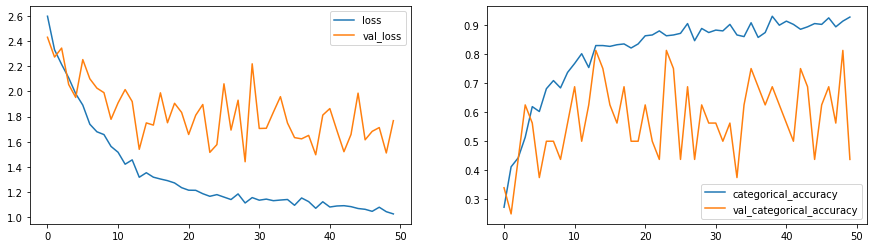

In [14]:
plot(history)